<a id='intro'></a>
## Introduction

### Dataset Description 
This data from Kaggle and you can download it from <a href="https://www.kaggle.com/deepak525/investigate-tmdb-movie-">Kaggle dataset</a>

This dataset contains information about 10,000 movies collected from The Movie Database (TMDb), including user ratings and revenue.
we have here ['id', 'imdb_id', 'popularity', 'budget', 'revenue', 'original_title','cast', 'homepage', 'director', 'tagline', 'keywords', 'overview','runtime', 'genres', 'production_companies', 'release_date','vote_count', 'vote_average', 'release_year', 'budget_adj','revenue_adj']

I think we don't need ['homepage','tagline','overview','imdb_id','keywords','budget_adj','revenue_adj','production_companies','popularity','cast','vote_count']

we'll use ['budget', 'revenue'] to get the profit and cost of movies, the financial part, ['genres'] column to determine which one is the most common...etc, column ['release_date'] to deal with time and year, column ['vote_average'] to determine which had high, and low vote.

### Question(s) for Analysis
Q1: Is there a correlation between runtime and average vote?

Q2: What is the most common genre? and in the top 100?

Q3: Which genre costs the much? and which doesn't?

Q4: Is there a correlation between cost and revenue in the top 100?

Q5: What is the lowest budget movie in every year for the past 10 years?

Q6: What is the highest profit movie on the list?


# Import

In [2]:
#Import section
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import collections
%matplotlib inline

# Data Overview

In [3]:
# Load your data and print out a few lines. Perform operations to inspect data
# types and look for instances of missing or possibly errant data.
df = pd.read_csv('tmdb-movies.csv',engine='python')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10866 non-null  int64  
 1   imdb_id               10856 non-null  object 
 2   popularity            10866 non-null  float64
 3   budget                10866 non-null  int64  
 4   revenue               10866 non-null  int64  
 5   original_title        10866 non-null  object 
 6   cast                  10790 non-null  object 
 7   homepage              2936 non-null   object 
 8   director              10822 non-null  object 
 9   tagline               8042 non-null   object 
 10  keywords              9373 non-null   object 
 11  overview              10862 non-null  object 
 12  runtime               10866 non-null  int64  
 13  genres                10843 non-null  object 
 14  production_companies  9836 non-null   object 
 15  release_date       

# Clean Data

## Drop unnecessary columns

In [3]:
#first I'll drop the columns that I don't need
df = df.drop(['homepage','tagline','overview','imdb_id','keywords','budget_adj','revenue_adj','production_companies','popularity','cast','vote_count'], axis = 1)
df.head()

,id,budget,revenue,original_title,director,runtime,genres,release_date,vote_average,release_year
0,135397,150000000,1513528810,Jurassic World,Colin Trevorrow,124,Action|Adventure|Science Fiction|Thriller,6/9/15,6.5,2015
1,76341,150000000,378436354,Mad Max: Fury Road,George Miller,120,Action|Adventure|Science Fiction|Thriller,5/13/15,7.1,2015
2,262500,110000000,295238201,Insurgent,Robert Schwentke,119,Adventure|Science Fiction|Thriller,3/18/15,6.3,2015
3,140607,200000000,2068178225,Star Wars: The Force Awakens,J.J. Abrams,136,Action|Adventure|Science Fiction|Fantasy,12/15/15,7.5,2015
4,168259,190000000,1506249360,Furious 7,James Wan,137,Action|Crime|Thriller,4/1/15,7.3,2015


## Drop NaN

In [4]:
#now lets see the NAN vulaes
df.isnull().sum()

id                 0
budget             0
revenue            0
original_title     0
director          44
runtime            0
genres            23
release_date       0
vote_average       0
release_year       0
dtype: int64

In [5]:
#now lets drop the null values we can't fill it with mean or any data
df.dropna(inplace = True)
#check if we still have null
df.isnull().sum()

id                0
budget            0
revenue           0
original_title    0
director          0
runtime           0
genres            0
release_date      0
vote_average      0
release_year      0
dtype: int64

## Clean Duplicated

In [6]:
#duplicated rows time
#let's check it first
sum(df.duplicated())

1

In [7]:
#we have one, I prefer dropping it 
df.drop_duplicates(inplace = True)
#let;s check if we are done
sum(df.duplicated())

0

## Fix Data Type

In [8]:
#now time data type and we are going to fix 'release_date' column
df['release_date'] = pd.to_datetime(df['release_date'])
df['release_date_1'] = df['release_date'].dt.day.astype(str) + "-" + df['release_date'].dt.month.astype(str) + "-" + df['release_year'].astype(str)
df['release_date_1'] = pd.to_datetime(df['release_date_1'])
df.drop(['release_date','release_year'],axis = 1,inplace = True)
df.rename(columns = {'release_date_1' : 'release_date'},inplace = True)

In [9]:
df.head()

,id,budget,revenue,original_title,director,runtime,genres,vote_average,release_date
0,135397,150000000,1513528810,Jurassic World,Colin Trevorrow,124,Action|Adventure|Science Fiction|Thriller,6.5,2015-09-06
1,76341,150000000,378436354,Mad Max: Fury Road,George Miller,120,Action|Adventure|Science Fiction|Thriller,7.1,2015-05-13
2,262500,110000000,295238201,Insurgent,Robert Schwentke,119,Adventure|Science Fiction|Thriller,6.3,2015-03-18
3,140607,200000000,2068178225,Star Wars: The Force Awakens,J.J. Abrams,136,Action|Adventure|Science Fiction|Fantasy,7.5,2015-12-15
4,168259,190000000,1506249360,Furious 7,James Wan,137,Action|Crime|Thriller,7.3,2015-01-04


In [10]:
# now let's deal with the 'genres' column
# I prefer to deal with it in separate df
# to avoid extending the original df with no need to it, we only need genres and movie names and its revenue
df_genres = df['genres'].str.split('|',expand = True).join(df['original_title'])
#I think we should change the columns name
df_genres.rename(columns = {0:'genre_1',1:'genre_2',2:'genre_3',3:'genre_4',4:'genre_5'},inplace = True)
df_genres.head()

,genre_1,genre_2,genre_3,genre_4,genre_5,original_title
0,Action,Adventure,Science Fiction,Thriller,None,Jurassic World
1,Action,Adventure,Science Fiction,Thriller,None,Mad Max: Fury Road
2,Adventure,Science Fiction,Thriller,None,None,Insurgent
3,Action,Adventure,Science Fiction,Fantasy,None,Star Wars: The Force Awakens
4,Action,Crime,Thriller,None,None,Furious 7


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10800 entries, 0 to 10865
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              10800 non-null  int64         
 1   budget          10800 non-null  int64         
 2   revenue         10800 non-null  int64         
 3   original_title  10800 non-null  object        
 4   director        10800 non-null  object        
 5   runtime         10800 non-null  int64         
 6   genres          10800 non-null  object        
 7   vote_average    10800 non-null  float64       
 8   release_date    10800 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(4), object(3)
memory usage: 1.1+ MB


## Replace Zeros

In [12]:
df.describe()
# there are 3 columns with min 0 value that means at least this column has 1 zero value

,id,budget,revenue,runtime,vote_average
count,10800.000000,1.080000e+04,1.080000e+04,10800.000000,10800.000000
mean,65576.183426,1.471114e+07,4.006558e+07,102.189722,5.970880
std,91756.079939,3.098677e+07,1.173193e+08,30.783873,0.933006
min,5.000000,0.000000e+00,0.000000e+00,0.000000,1.500000
25%,10570.500000,0.000000e+00,0.000000e+00,90.000000,5.400000
50%,20460.000000,0.000000e+00,0.000000e+00,99.000000,6.000000
75%,74725.250000,1.564374e+07,2.455409e+07,111.250000,6.600000
max,417859.000000,4.250000e+08,2.781506e+09,900.000000,9.200000


In [13]:
#to fix that we will replace zeros with mean
df['budget'] = df['budget'].replace(0,df['budget'].mean())
df['revenue'] = df['revenue'].replace(0,df['revenue'].mean())
df['runtime'] = df['runtime'].replace(0,df['runtime'].mean())

In [14]:
df.describe()

,id,budget,revenue,runtime,vote_average
count,10800.000000,1.080000e+04,1.080000e+04,10800.000000,10800.000000
mean,65576.183426,2.238817e+07,6.214616e+07,102.454659,5.970880
std,91756.079939,2.807649e+07,1.113169e+08,30.339749,0.933006
min,5.000000,1.000000e+00,2.000000e+00,2.000000,1.500000
25%,10570.500000,1.471114e+07,4.006558e+07,90.000000,5.400000
50%,20460.000000,1.471114e+07,4.006558e+07,99.000000,6.000000
75%,74725.250000,1.564374e+07,4.006558e+07,111.250000,6.600000
max,417859.000000,4.250000e+08,2.781506e+09,900.000000,9.200000


## Outliers

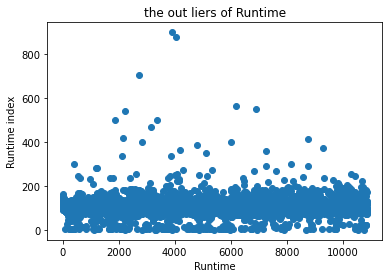

In [15]:
#we need to see if there's outlier value
plt.scatter(df['runtime'].index,df['runtime'])
plt.xlabel("Runtime")
plt.ylabel("Runtime index")
plt.title("the out liers of Runtime");

### it seems that we have some out liers here, most of them above 200 mins we need to deal with that

In [16]:
df['runtime'].describe()

count    10800.000000
mean       102.454659
std         30.339749
min          2.000000
25%         90.000000
50%         99.000000
75%        111.250000
max        900.000000
Name: runtime, dtype: float64

In [17]:
#we will put a threshold by 3 std from mean
up_limit = df['runtime'].mean() + (df['runtime'].std()*3)
down_limit = df['runtime'].mean() - (df['runtime'].std()*3)

In [18]:
#and now we need to loc the outlier
df.loc[(df['runtime']>= up_limit),'runtime'] = np.NaN
df.loc[(df['runtime']<= down_limit),'runtime'] = np.NaN

In [19]:
#now time to fill it with mean
df['runtime'].fillna(df['runtime'].mean(), inplace = True)

In [20]:
#just check
df['runtime'].describe()

count    10800.000000
mean       102.009739
std         20.035116
min         12.000000
25%         90.000000
50%         99.000000
75%        111.000000
max        193.000000
Name: runtime, dtype: float64

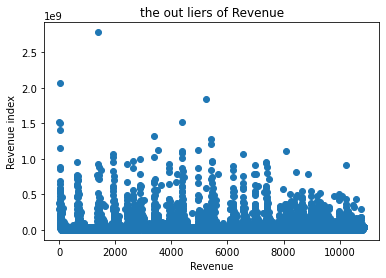

In [21]:
#we need to see if there's outlier value
plt.scatter(df['revenue'].index,df['revenue'])
plt.xlabel("Revenue")
plt.ylabel("Revenue index")
plt.title("the out liers of Revenue");

### I think we are good here, some movies get profit more away than the others, so we don't have outliers here.

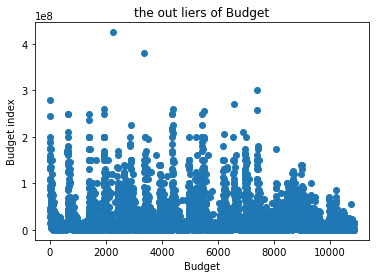

In [22]:
#we need to see if there's outliers value
plt.scatter(df['budget'].index,df['budget'])
plt.xlabel("Budget")
plt.ylabel("Budget index")
plt.title("the out liers of Budget");

### I think we are good here, some movies cost more than the othersو so we don't have outliers here.

# Q1: Is there a correlation  between runtime and average vote?

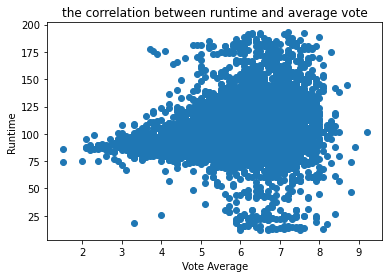

In [23]:
#to answer that we will plot them
plt.scatter(df['vote_average'],df['runtime'])
plt.xlabel("Vote Average")
plt.ylabel("Runtime")
plt.title("the correlation between runtime and average vote");

### Clearly there's no correlation, there's a lot of movies under 50 mins get high vote ad also many of above 125 get high vite too

# Q2: What is the most common genre? and in top 100?

In [24]:
#to answer that we need collect all genres in one dict with all values and keys
genres_dict = dict(collections.Counter(df_genres['genre_1'].value_counts().to_dict()) +
              collections.Counter(df_genres['genre_2'].value_counts().to_dict()) + 
              collections.Counter(df_genres['genre_3'].value_counts().to_dict()) + 
              collections.Counter(df_genres['genre_4'].value_counts().to_dict()) + 
              collections.Counter(df_genres['genre_5'].value_counts().to_dict())
             )

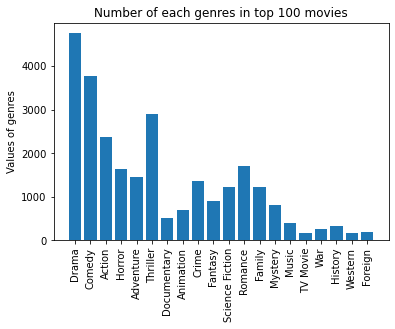

In [25]:
#ploting the result
genres_list = list(genres_dict.keys())
plt.bar(genres_dict.keys(),genres_dict.values())
plt.xticks(rotation=90)
plt.ylabel("Values of genres")
plt.title('Number of each genres in top 100 movies');

### Drama is the most common genre in all datasets, it's far from any genres

In [26]:
#lets create a function we can use to get the key by value
def get_key(d, v):
    #return the key of value v from dict d
    for key, val in d.items():
        if v == val:
            return key

### The Drama is the most common genre in all movies

In [27]:
"There's {} {} Movies and only {} {} movies".format(max(genres_dict.values()),
                                                        get_key(genres_dict,max(genres_dict.values())),
                                                        min(genres_dict.values()),
                                                        get_key(genres_dict,min(genres_dict.values()))
                                                   )

"There's 4754 Drama Movies and only 162 TV Movie movies"

In [28]:
#lets see in top 100
#first we need to add [vote_average] to df_genres
df_genres = df_genres.join(df['vote_average'])

In [29]:
#now lets see top 100
df_top_100 = df_genres.sort_values('vote_average').tail(100)
df_top_100

,genre_1,genre_2,genre_3,genre_4,genre_5,original_title,vote_average
6170,Drama,Family,None,None,None,Anne of Green Gables,7.9
1105,Documentary,None,None,None,None,Interstellar: Nolan's Odyssey,7.9
7310,Horror,Thriller,None,None,None,The Shining,7.9
7888,Drama,Crime,None,None,None,Once Upon a Time in America,7.9
10144,Comedy,Drama,Romance,None,None,The Apartment,7.9
...,...,...,...,...,...,...,...
6911,Music,None,None,None,None,Pink Floyd: Pulse,8.7
2269,Documentary,None,None,None,None,Life Cycles,8.8
1200,Drama,Horror,Mystery,Science Fiction,Thriller,Black Mirror: White Christmas,8.8
538,Documentary,None,None,None,None,The Mask You Live In,8.9


In [30]:
#create a dict with genres as keys and number of each gener in top 100 as a values
genres_dict = dict(collections.Counter(df_top_100['genre_1'].value_counts().to_dict()) +
              collections.Counter(df_top_100['genre_2'].value_counts().to_dict()) + 
              collections.Counter(df_top_100['genre_3'].value_counts().to_dict()) + 
              collections.Counter(df_top_100['genre_4'].value_counts().to_dict()) + 
              collections.Counter(df_top_100['genre_5'].value_counts().to_dict())
             )

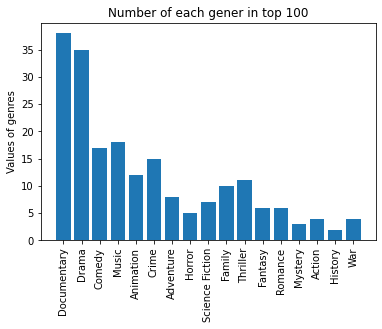

In [31]:
#ploting the dict
plt.bar(genres_dict.keys(),genres_dict.values())
plt.xticks(rotation=90)
plt.ylabel("Values of genres")
plt.title('Number of each gener in top 100');

### I didn't see that coming, Documentary is most common genre in top 100!

In [32]:
"There's {} {} Movies and only {} {} movies".format(max(genres_dict.values()),
                                                        get_key(genres_dict,max(genres_dict.values())),
                                                        min(genres_dict.values()),
                                                        get_key(genres_dict,min(genres_dict.values()))
                                                   )

"There's 38 Documentary Movies and only 2 History movies"

# Q3: Which genre cost the much? and which doesn't?

In [33]:
#we need to add ['budget'] column to df_genres
df_genres = df_genres.join(df['budget'])

In [34]:
#create a dict with a genres as a keys and empty list as values
gens_list = list(genres_dict.keys())
gens_dict = dict.fromkeys(gens_list,[])

In [35]:
#add the vaules to dict
for gen in gens_dict:
    df_genres_a = df_genres.loc[(df_genres['genre_1'] == gen)]
    df_genres_a.sort_values('vote_average',inplace = True)
    gens_dict.update({gen:df_genres_a['budget'].tail(5).sum()})

C:\Users\ammar\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


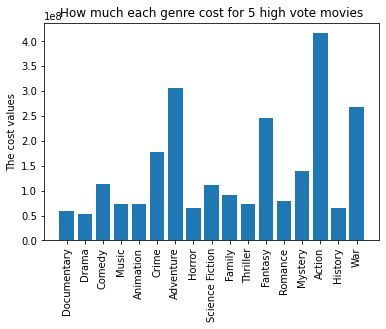

In [36]:
#time for plot
plt.bar(gens_dict.keys(),gens_dict.values())
plt.title('How much each genre cost for 5 high vote movies')
plt.xticks(rotation=90)
plt.ylabel("The cost values");

### Action is cost a lot between all genres in top 5 for every genre.

In [37]:
"The top 5 movies in {} genre is cost {}$, while the top 5 movies in {} cots {}$.".format(
    get_key(gens_dict,max(gens_dict.values())),
    round(max(gens_dict.values())),
    get_key(gens_dict,min(gens_dict.values())),
    round(min(gens_dict.values())))

'The top 5 movies in Action genre is cost 416087937$, while the top 5 movies in Drama cots 53011137$.'

# Q4: Is there a correlation between cost and revenue in top 100?

In [38]:
# we need to add 2 columns ['budget'] and ['revenue']
df_top_100 = df_top_100.join(df['budget']).join(df['revenue'])

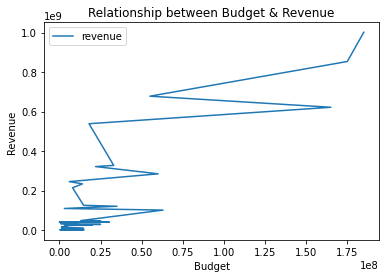

In [39]:
df_top_100.sort_values('revenue').plot('budget','revenue')
plt.title('Relationship between Budget & Revenue')
plt.ylabel("Revenue")
plt.xlabel("Budget");

### Yes there's a positive correlation between Budget and Revenue, I can see clearly that there's a correlation between them, as the Budget raise the Revenue raise also, for sure there's some out liers, but the main idea is that there's a correlation.

# Q5: What is the lowest budget movie in every year for past 10 years?

In [40]:
#we need to put range of 10 in df
max_year = df['release_date'].dt.year.max()
df_last_10 = df.loc[(df['release_date'].dt.year > (max_year-10)) & (df['release_date'].dt.year <= max_year)]

In [41]:
#now we are going to groupby the year and min function to get the lowest budget for every year
df_last_10.groupby(df_last_10['release_date'].dt.year).min()

,id,budget,revenue,original_title,director,runtime,genres,vote_average,release_date
release_date,,,,,,,,,
2006,17,2500.0,144.0,10 Items or Less,Aaron Seltzer|Jason Friedberg,14.0,Action,2.8,2006-01-01
2007,35,12.0,46.0,1408,Adam Shankman,13.0,Action,1.5,2007-01-01
2008,155,1.0,3.0,$5 a Day,A.R. Murugadoss,12.0,Action,2.6,2008-01-01
2009,534,75.0,80.0,(500) Days of Summer,Abel Ferry,16.0,Action,3.1,2009-01-01
2010,7978,3.0,10.0,127 Hours,Aaron Schneider,12.0,Action,2.1,2010-01-01
2011,1771,1.0,15.0,10 Years,FrÃ©dÃ©ric Jardin,13.0,Action,2.1,2011-01-01
2012,1930,17.0,30.0,100 Bloody Acres,Adam Shankman,12.0,Action,2.0,2012-01-01
2013,4258,10.0,11.0,1,Abe Levy|Silver Tree,15.0,Action,2.2,2013-01-01
2014,189,1.0,2710.0,'71,Aaron Katz|Martha Stephens,14.0,Action,2.4,2014-01-01


# Q6: What is the highest profit movie the list?

In [42]:
#we need to create a column called ['profit'] where we are going to subtract the revenue from budget
df['profit'] = df['revenue'] - df['budget']

In [43]:
df.loc[(df['profit'] == df['profit'].max())]

,id,budget,revenue,original_title,director,runtime,genres,vote_average,release_date,profit
1386,19995,237000000.0,2.781506e+09,Avatar,James Cameron,162.0,Action|Adventure|Fantasy|Science Fiction,7.1,2009-10-12,2.544506e+09


### no wondering

## Conclusions

First I thought that there’s a correlation between the Runtime and Average Vote that can get, but I was wrong, and that leads me to the second question.
 
“What is the most common genre? and in top 100?”, I know that could be wired, but we all thought that the most common genre in movies is “Action” but what I found was ‘Drama’ 4754 movie from 10800 movies in the list is for drama, and the rest are for the rest of genres ‘19’, but what about the top 100, and I found that ‘Documentary’ genre is the most in top 100, I think that is why there’s no correlation between the runtime and average vote.

Then I wounding is action costs a lot so they don’t produce it a lot like drama, and that was my third question “Which genre cost the much? and which doesn’t?“ and the answer was “yes” action cost a lot that’s why they don’t produce it as drama.
 
Then I asked myself “Is there a correlation between cost and revenue in the top 100?” so if they cost a lot sure they get high profit also, and I found it “Yes” there’s a correlation.
 
I still didn’t get a clear answer to my question if they cost a lot and get high profit why drama is the most common one? so I thought maybe action in the past 10 years costed a lot more than now, so I Sought “What is the lowest budget movie in every year for the past 10 years?” and I found the past 10 is all action.
 
And now for the last question “What is the highest profit movie on the list?“, and it was “Avatar” action also, my conclusion is, maybe people watch drama a lot and give the high vote to Documentary movies but the action movies get the high profit at the end of the day.


## Limitations 

we can see that the outliers of the runtime column were unbelievable, some values was over 800 mins and that totally out of any acceptable range, I tried to fill that with a mean of runtime but that makes me think is that a human or machine fault, anyway we just handle that case.

the zeros values also were very tricky and need to be detected and replaced, there are many zeros values and that makes you wonder is that missing data or not valuable data or just human fault.